In [3]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string, re, time
from pprint import pprint
from urllib.request import urlopen
from urllib.parse import quote    

# Set default plot size so graphs will be more readable
plt.rcParams['figure.figsize'] = [9, 7]

In [4]:
df_raw = pd.read_csv('raw_scrape.csv') # Scraped with scrapy using a seperate script 
df_raw['btag'] = df_raw['btag'].str.split(',')

# Preliminary exploration... 
df_raw['member_count'] = df_raw.btag.str.len()
df_raw.groupby('member_count').count()['btag']


member_count
1.0      81
2.0      28
3.0       8
4.0      10
5.0       9
6.0      39
7.0      92
8.0     137
9.0     123
10.0     12
11.0      1
Name: btag, dtype: int64

Somehow, one team has 11 members (max allowed is 9+1 community manager). A concurrency problem when inserting into the Tespa database, or a special exception?

In [41]:
# Wait, what?
df_10 = df_raw.query('member_count == 11')
df_10

,team_name,team_link_url,btag,member_count
367,UNT Mean Green,https://compete.tespa.org/tournament/111/team/...,"[Moose#14664, Samston#11240, FierceSerge#1901,...",11.0


In [6]:
df_valid = df_raw.query('member_count > 5')

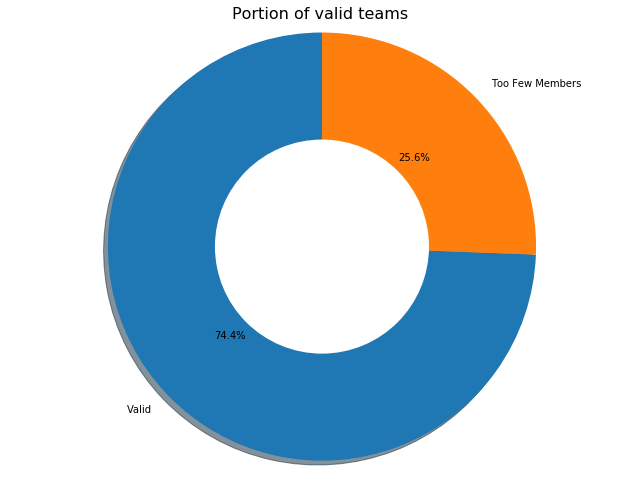

In [7]:
labels = ['Valid', 'Too Few Members']
sizes = [len(df_valid), len(df_raw) - len(df_valid)]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)

# Plot
centre_circle = plt.Circle((0,0),0.5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
fig.suptitle('Portion of valid teams', fontsize=16)
 
plt.axis('equal')
plt.tight_layout()
plt.show()

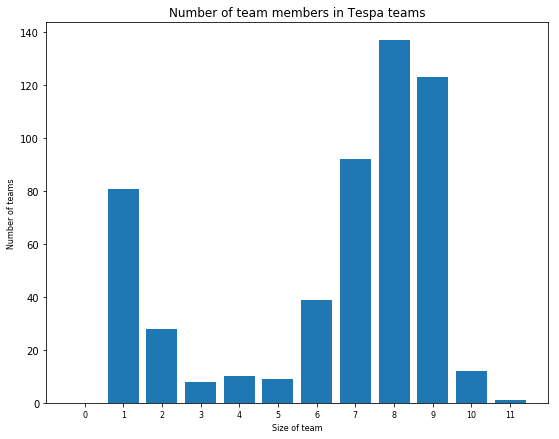

In [51]:
labels_count = list(range(12))
sizes_count = [len(df_raw.query('member_count == {}'.format(i)).index) for i in labels_count]
fig1, ax1 = plt.subplots()

index = np.arange(len(labels_count))
plt.bar(labels_count, sizes_count)
plt.xlabel('Size of team', fontsize=8)
plt.ylabel('Number of teams', fontsize=8)
plt.xticks(index, labels_count, fontsize=8)
plt.title('Number of team members in Tespa teams')
plt.show()

In [9]:
# Unpack lists of team members into rows
s = df_valid.apply(lambda x: pd.Series(x['btag']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'btag'
df_btags = df_valid.drop('btag', axis=1).join(s).reset_index(drop=True)
df_btags = df_btags[['btag', 'team_name']]

Now for the fun stuff, scraping player profiles for each btag collected. Takes about an hour using the default request delay of 0.2s plus processing time.

In [52]:
count = 0

def parse_re_int(reg, rawhtml):
    matchObj = re.search(reg ,rawhtml)
    if matchObj == None: 
        return None
    else:
        return int(matchObj.group(1))
    
def parse_re_str(reg, rawhtml):
    matchObj = re.search(reg ,rawhtml)
    if matchObj == None: 
        return None
    else:
        return str(matchObj.group(1))

def get_stats(btag):
    global count
    if count % 25 == 0:
        print("Parsed btags:", count)
    re_sr = r'u-align-center h5">(\d{3,4})<'
    re_comp_main = r'data-hero-competitive="(\w{1,})"'
    re_qp_main = r'data-hero-quickplay="(\w{1,})"'
    
    url_prefix = 'https://playoverwatch.com/en-us/career/pc/'
    url = url_prefix + quote(btag)
    try:
        rawhtml = urlopen(url).read().decode('utf-8')
    except:
        return ["Scrape fault"] * 3
    time.sleep(0.20) # add delay between requests
    count += 1 # progress indication
    
    return [parse_re_int(re_sr, rawhtml), parse_re_str(re_comp_main, rawhtml), parse_re_str(re_qp_main, rawhtml)]


In [54]:
# Use this to test if what is being scraped is what you expect
#df_sample = df_btags.sample(25)
#df_sample[['SR', 'Comp_main', 'QP_main']] = df_sample.apply(lambda row: pd.Series(get_stats(row['btag'].replace('#','-'))),axis=1)
#df_sample

# Takes a long time to scrape all 3.2k players
df_btags[['SR', 'Comp_main', 'QP_main']] = df_btags.apply(lambda row: pd.Series(get_stats(row['btag'].replace('#','-'))),axis=1)
df_btags


,btag,team_name,SR,Comp_main,QP_main,rank
0,AceOfSpades#11850,Penn State Harmony,2357.0,hanzo,hanzo,gold
1,SolarFlamez#1839,Penn State Harmony,2673.0,NaN,NaN,plat
2,FosterWalrus#1344,Penn State Harmony,NaN,None,winston,NaN
3,ALLinTheGAME#11816,Penn State Harmony,2500.0,NaN,NaN,gold
4,DeadKnight#11476,Penn State Harmony,2380.0,dva,dva,gold
5,漂白白#4808,Penn State Harmony,NaN,None,None,NaN
6,Thor#12751,Penn State Harmony,3074.0,zarya,None,diamond
7,Enchilada#11845,Penn State Harmony,NaN,None,None,NaN
8,PSUKicus#1510,Penn State Harmony,3337.0,zarya,pharah,diamond
9,McRaeMan#1505,UNF Varsity Blue,2828.0,zarya,zarya,plat


In [21]:
# Add a categorical rank based on SR
bins = [0, 1500, 2000, 2500, 3000, 3500, 4000, 4250, 4500, 4750, 5000]
labels = ['bronze','silver','gold','plat','diamond','masters','gm','semipro','pro','god']
df_btags['rank'] = pd.cut(df_btags['SR'], bins=bins, labels=labels)
df_btags['rank']

# Make sure to save our scrape!
df_btags.to_csv('btags.csv')

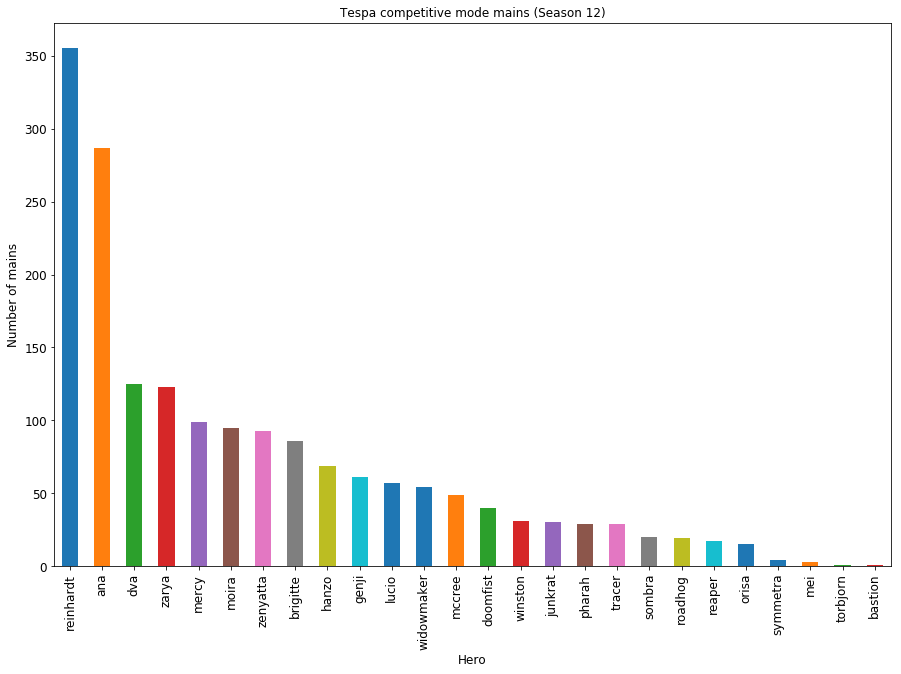

In [22]:
ax = pd.value_counts(df_btags['Comp_main']).plot(kind='bar', title ="Tespa competitive mode mains (Season 12)", figsize=(15, 10), legend=False, fontsize=12)
ax.set_xlabel("Hero", fontsize=12)
ax.set_ylabel("Number of mains", fontsize=12)
plt.show()

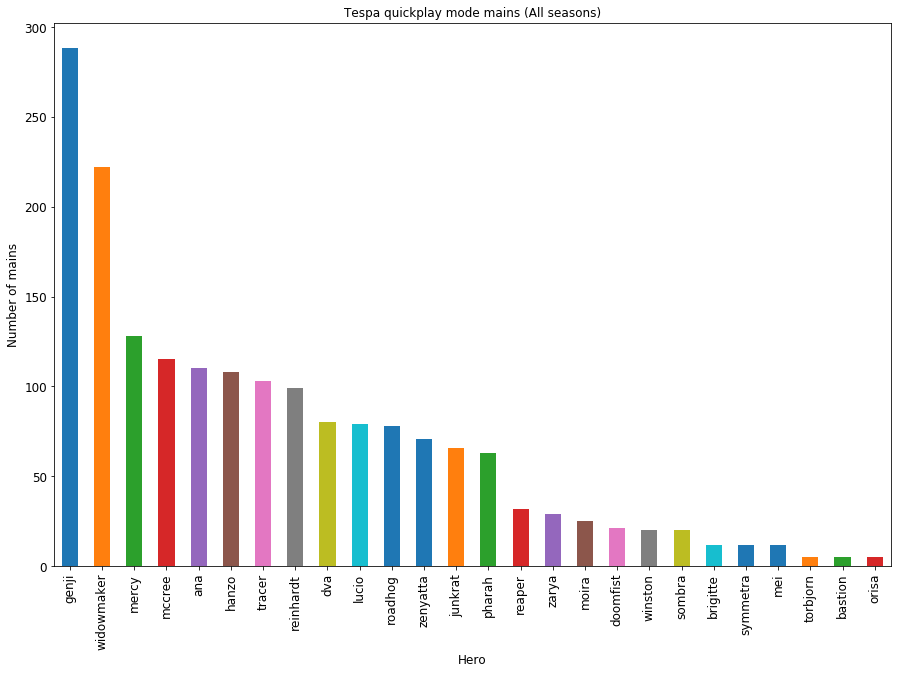

In [23]:
ax = pd.value_counts(df_btags['QP_main']).plot(kind='bar', title ="Tespa quickplay mode mains (All seasons)", figsize=(15, 10), legend=False, fontsize=12)
ax.set_xlabel("Hero", fontsize=12)
ax.set_ylabel("Number of mains", fontsize=12)
plt.show()

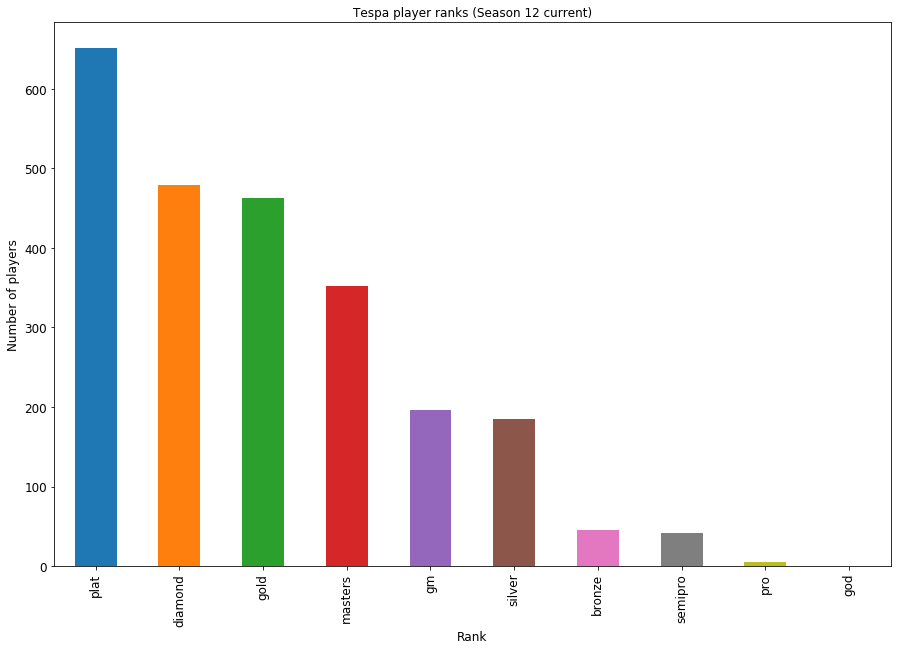

In [24]:
ax = pd.value_counts(df_btags['rank']).plot(kind='bar', title ="Tespa player ranks (Season 12 current)", figsize=(15, 10), legend=False, fontsize=12)
ax.set_xlabel("Rank", fontsize=12)
ax.set_ylabel("Number of players", fontsize=12)
plt.show()

**Note**: gm = 4000-4250, semipro = 4250-4500, pro = 4500-4750, god = 4750-5000

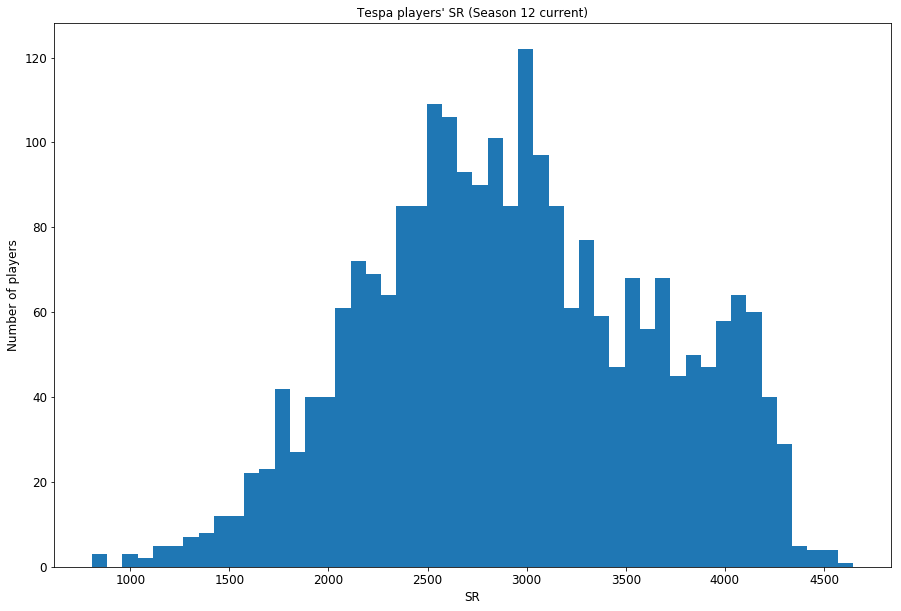

In [25]:
ax = df_btags['SR'].plot(kind='hist',title ="Tespa players' SR (Season 12 current)", bins=50,figsize=(15, 10), legend=False, fontsize=12)
ax.set_xlabel("SR", fontsize=12)
ax.set_ylabel("Number of players", fontsize=12)
plt.show()

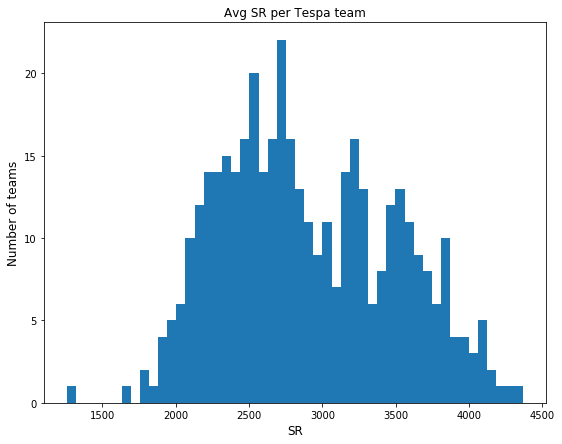

In [26]:
team_means = df_btags.groupby(['team_name'])['SR'].mean().sort_values()
ax = team_means.plot(kind='hist', bins=50, title='Avg SR per Tespa team') 
ax.set_xlabel("SR", fontsize=12)
ax.set_ylabel("Number of teams", fontsize=12)
plt.show()

In [39]:
# Tool to help my team scout by profiling a specific team
def get_team_info(team_name):
    global df_btags, team_means
    
    target = df_btags['team_name'] == team_name
    target = df_btags[target][['btag', 'SR', 'Comp_main', 'QP_main']]
    print (team_name)
    print (target)
    print ("Average SR:", team_means[team_name])

get_team_info('Maryville University')

Maryville University
              btag      SR Comp_main     QP_main
1331  TWISTan#1368  4313.0    tracer  widowmaker
1332  snooze#11741  4202.0       NaN         NaN
1333    AXEL#25467  4425.0       ana  widowmaker
1334      Rat#2968  4502.0    tracer      mccree
1335    Guru#11168  4516.0       dva      pharah
1336      Mac#1512  4276.0     lucio      mccree
1337  Aether#12627  4299.0     genji       genji
1338  Hypnott#1559  4430.0   winston  widowmaker
Average SR: 4370.375
